<a href="https://colab.research.google.com/github/porphyrie/secure-coding-practices/blob/main/Static_Analysis_Concepts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tokenize
import io

# source code to tokenize
source_code = """
def unsafe_query(user_input):
    query = "SELECT * FROM users WHERE name = '" + user_input + "'"
    cursor.execute(query)
"""

# convert the source code to bytes and use io.BytesIO for a file-like interface
source_bytes = io.BytesIO(source_code.encode('utf-8'))

# tokenize and collect information
tokens = tokenize.tokenize(source_bytes.readline)

# print token information
for token in tokens:
    tok_type = tokenize.tok_name[token.type]
    string = token.string
    start = token.start
    print(f"({tok_type}, '{string}', {start})")


(ENCODING, 'utf-8', (0, 0))
(NL, '
', (1, 0))
(NAME, 'def', (2, 0))
(NAME, 'unsafe_query', (2, 4))
(OP, '(', (2, 16))
(NAME, 'user_input', (2, 17))
(OP, ')', (2, 27))
(OP, ':', (2, 28))
(NEWLINE, '
', (2, 29))
(INDENT, '    ', (3, 0))
(NAME, 'query', (3, 4))
(OP, '=', (3, 10))
(STRING, '"SELECT * FROM users WHERE name = '"', (3, 12))
(OP, '+', (3, 49))
(NAME, 'user_input', (3, 51))
(OP, '+', (3, 62))
(STRING, '"'"', (3, 64))
(NEWLINE, '
', (3, 67))
(NAME, 'cursor', (4, 4))
(OP, '.', (4, 10))
(NAME, 'execute', (4, 11))
(OP, '(', (4, 18))
(NAME, 'query', (4, 19))
(OP, ')', (4, 24))
(NEWLINE, '
', (4, 25))
(DEDENT, '', (5, 0))
(ENDMARKER, '', (5, 0))


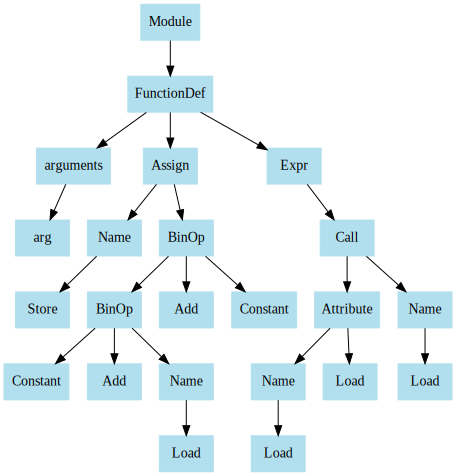

In [ ]:
import ast
import graphviz

# visitor class to traverse the AST nodes and create a Graphviz graph
class ASTVisualizer(ast.NodeVisitor):
    def __init__(self):
        self.graph = graphviz.Digraph('AST', node_attr={'shape': 'box', 'color': 'lightblue2', 'style': 'filled'})
        self.node_count = 0

    def generic_visit(self, node):
        label = type(node).__name__
        # Create a unique node name using the count of nodes
        node_name = f'node{self.node_count}'
        self.node_count += 1

        # Add the node to the graph with its label
        self.graph.node(node_name, label=label)

        # Visit all the child nodes
        for field, value in ast.iter_fields(node):
            if isinstance(value, list):
                for item in value:
                    if isinstance(item, ast.AST):
                        child_name = self.generic_visit(item)
                        self.graph.edge(node_name, child_name)
            elif isinstance(value, ast.AST):
                child_name = self.generic_visit(value)
                self.graph.edge(node_name, child_name)

        return node_name

# source code to parse into an AST
source_code = """
def unsafe_query(user_input):
    query = "SELECT * FROM users WHERE name = '" + user_input + "'"
    cursor.execute(query)
"""

# parse the source code into an AST
parsed_ast = ast.parse(source_code)

# instantiate the visualizer and visit the root of the AST
visualizer = ASTVisualizer()
visualizer.visit(parsed_ast)

# render the graph
visualizer.graph

SIMPLE DETECTION OF STRING CONCATENATION

In [ ]:
import ast

class SQLInjectionDetector(ast.NodeVisitor):
    def visit_BinOp(self, node):
        # check if this binary operation is string concatenation
        if isinstance(node.op, ast.Add):
            # check if one of the operands is a Str node (simple case)
            if isinstance(node.left, ast.Str) or isinstance(node.right, ast.Str):
                print(f"Potential SQL injection vulnerability detected at line {node.lineno}")
        # continue traversing the AST
        self.generic_visit(node)

# example code to analyze
source_code = """
def unsafe_query(user_input):
    query = "SELECT * FROM users WHERE name = '" + user_input + "'"
    cursor.execute(query)
"""

# parse the source code into an AST
parsed_code = ast.parse(source_code)

# create an instance of our detector and visit the AST
detector = SQLInjectionDetector()
detector.visit(parsed_code)


Potential SQL injection vulnerability detected at line 3
Potential SQL injection vulnerability detected at line 3


SIMPLE DETECTION OF STRING CONCATENATION, STRING FORMATTING

In [ ]:
import ast

class SQLInjectionDetector(ast.NodeVisitor):
    def visit_BinOp(self, node):
        # check for % formatting in addition to concatenation
        if isinstance(node.op, (ast.Add, ast.Mod)) and self._is_string(node.left):
            print(f"Potential SQL injection vulnerability detected (using % or +) at line {node.lineno}")
        self.generic_visit(node)

    def visit_Call(self, node):
        # check for str.format()
        if isinstance(node.func, ast.Attribute) and node.func.attr == 'format' and self._is_string(node.func.value):
            print(f"Potential SQL injection vulnerability detected (using str.format) at line {node.lineno}")
        self.generic_visit(node)

    def visit_JoinedStr(self, node):
        # basic check for f-strings, more complex analysis needed for real cases
        print(f"Potential SQL injection vulnerability detected (using f-string) at line {node.lineno}")
        self.generic_visit(node)

    def _is_string(self, node):
        return isinstance(node, (ast.Str, ast.Constant)) and isinstance(node.value, str)

# example code to analyze, including different string formatting methods
source_code = """
def unsafe_query_format(user_input):
    query = "SELECT * FROM users WHERE name = '{}'.format(user_input)"
    cursor.execute(query)

def unsafe_query_mod(user_input):
    query = "SELECT * FROM users WHERE name = '%s' % user_input"
    cursor.execute(query)

def unsafe_query_fstring(user_input):
    query = f"SELECT * FROM users WHERE name = '{user_input}'"
    cursor.execute(query)
"""

# parse the source code into an AST
parsed_code = ast.parse(source_code)

# create an instance of our detector and visit the AST
detector = SQLInjectionDetector()
detector.visit(parsed_code)

Potential SQL injection vulnerability detected (using f-string) at line 11


TAINT DETECTION

In [ ]:
import ast

class SQLInjectionDetector(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.tainted_variables = set()

    def visit_Call(self, node):
        # simplistic way to mark user input as tainted
        if isinstance(node.func, ast.Name) and node.func.id == 'input':
            if isinstance(node.parent, ast.Assign):
                for target in node.parent.targets:
                    if isinstance(target, ast.Name):
                        self.tainted_variables.add(target.id)
        self.generic_visit(node)

    def visit_BinOp(self, node):
        if isinstance(node.op, ast.Add):
            if self._is_tainted(node.left) or self._is_tainted(node.right):
                print(f"Potential SQL injection vulnerability detected at line {node.lineno}")
        self.generic_visit(node)

    def _is_tainted(self, node):
        if isinstance(node, ast.Name) and node.id in self.tainted_variables:
            return True
        return False

    def visit(self, node):
        # custom visit to set parent nodes, simplistic
        for child in ast.iter_child_nodes(node):
            child.parent = node
        super().visit(node)

# example code to analyze
source_code = """
user_input = input("Enter your name: ")
query = "SELECT * FROM users WHERE name = '" + user_input + "'"
"""

# parse the source code into an AST
parsed_code = ast.parse(source_code)

# create an instance of our detector and visit the AST
detector = SQLInjectionDetector()
detector.visit(parsed_code)


Potential SQL injection vulnerability detected at line 3


TAINT AND SANITIZATION DETECTION

In [ ]:
import ast

class SQLInjectionDetector(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        # track both tainted and sanitized variables
        self.tainted_variables = set()
        self.sanitized_variables = set()

    def visit_Call(self, node):
        # mark variables as tainted when receiving user input
        if isinstance(node.func, ast.Name) and node.func.id in ['input', 'secure_input']:
            if isinstance(node.parent, ast.Assign):
                for target in node.parent.targets:
                    if isinstance(target, ast.Name):
                        if node.func.id == 'input':
                            self.tainted_variables.add(target.id)
                        # Assume secure_input is safe and does not taint the variable
        # check for sanitization
        elif isinstance(node.func, ast.Name) and node.func.id == 'sanitize_input':
            if isinstance(node.parent, ast.Assign):
                for target in node.parent.targets:
                    if isinstance(target, ast.Name):
                        self.sanitized_variables.add(target.id)
                        # Remove from tainted if it's sanitized
                        if target.id in self.tainted_variables:
                            self.tainted_variables.remove(target.id)
        self.generic_visit(node)

    def visit_BinOp(self, node):
        if isinstance(node.op, ast.Add):
            if self._is_tainted(node.left) or self._is_tainted(node.right):
                print(f"Potential SQL injection vulnerability detected at line {node.lineno}")
        self.generic_visit(node)

    def _is_tainted(self, node):
        # check if the variable is tainted and not sanitized
        if isinstance(node, ast.Name):
            return node.id in self.tainted_variables and node.id not in self.sanitized_variables
        return False

    def visit(self, node):
        # custom visit to set parent nodes, simplistic
        for child in ast.iter_child_nodes(node):
            child.parent = node
        super().visit(node)

# example code to analyze
source_code = """
user_input = input("Enter your name: ")
safe_input = sanitize_input(user_input)
query = "SELECT * FROM users WHERE name = '" + user_input + "'"  # This should be flagged
safe_query = "SELECT * FROM users WHERE name = '" + safe_input + "'"  # This should not
"""

# parse the source code into an AST
parsed_code = ast.parse(source_code)

# create an instance of our detector and visit the AST
detector = SQLInjectionDetector()
detector.visit(parsed_code)

Potential SQL injection vulnerability detected at line 4


ALL CONCEPTS

In [ ]:
import ast

class SQLInjectionDetector(ast.NodeVisitor):
    def __init__(self):
        super().__init__()
        self.tainted_variables = set()
        self.sanitized_variables = set()

    def visit_Assign(self, node):
        # Track assignments to propagate taint and sanitization status
        if isinstance(node.value, ast.Call) and isinstance(node.value.func, ast.Name):
            # If the right-hand side is a call to the input function, mark the variable as tainted
            if node.value.func.id == 'input':
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        self.tainted_variables.add(target.id)
            # If the right-hand side is a call to the sanitize_input function, mark as sanitized
            elif node.value.func.id == 'sanitize_input':
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        self.sanitized_variables.add(target.id)
                        # Remove from tainted if it was previously marked
                        if target.id in self.tainted_variables:
                            self.tainted_variables.remove(target.id)
        self.generic_visit(node)

    def visit_Call(self, node):
        # Flag calls to vulnerable patterns if they involve tainted variables
        if isinstance(node.func, ast.Name) and node.func.id in ['unsafe_query', 'safe_query']:
            if any(self._is_tainted(arg) for arg in node.args):
                # For `unsafe_query`, flag if arguments are tainted
                if node.func.id == 'unsafe_query':
                    self._flag_vulnerability(node)
                # For `safe_query`, also flag if the argument hasn't been sanitized
                elif node.func.id == 'safe_query' and not self._is_sanitized(node.args[0]):
                    self._flag_vulnerability(node)
        self.generic_visit(node)

    def _is_tainted(self, node):
        # Check if a node (variable) is marked as tainted
        return isinstance(node, ast.Name) and node.id in self.tainted_variables

    def _is_sanitized(self, node):
        # Check if a node (variable) is marked as sanitized
        return isinstance(node, ast.Name) and node.id in self.sanitized_variables

    def _flag_vulnerability(self, node):
        # Print a message flagging potential vulnerability
        print(f"Potential SQL injection vulnerability detected at line {node.lineno}")

# Define functions to represent different handling of user input
source_code = """
def unsafe_query(user_input):
    # Direct concatenation, unsafe
    return "SELECT * FROM users WHERE name = '" + user_input + "'"

def safe_query(user_input):
    # Uses sanitization, safer
    sanitized_input = sanitize_input(user_input)
    return "SELECT * FROM users WHERE name = '{}'".format(sanitized_input)

def sanitize_input(value):
    # Placeholder for input sanitization logic
    return value.replace("'", "''")

user_input = input("Enter your name: ")
query1 = unsafe_query(user_input)  # This should be flagged
query2 = safe_query(user_input)    # This should not be flagged if sanitize_input is effective
"""

# Parse the source code into an AST
parsed_code = ast.parse(source_code)

# Create an instance of our detector and visit the AST
detector = SQLInjectionDetector()
detector.visit(parsed_code)

Potential SQL injection vulnerability detected at line 16
Potential SQL injection vulnerability detected at line 17


In [ ]:
class Token:
    def __init__(self, type_, value):
        self.type = type_
        self.value = value

class TreeNode:
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, child):
        self.children.append(child)

class Parser:
    def __init__(self, tokens):
        self.tokens = tokens
        self.current_index = 0
        self.current_token = self.tokens[self.current_index] if self.tokens else None
        self.ast = TreeNode("Program")  # Root node of the AST

    def advance(self):
        self.current_index += 1
        if self.current_index < len(self.tokens):
            self.current_token = self.tokens[self.current_index]
        else:
            self.current_token = Token("ENDMARKER", "")

    def error(self, message):
        raise Exception(f"Error at token {self.current_token.value}: {message}")

    def match(self, expected_type, expected_value=None):
        if self.current_token and self.current_token.type == expected_type:
            if expected_value is None or self.current_token.value == expected_value:
                self.advance()
            else:
                self.error(f"Expected token value '{expected_value}', found '{self.current_token.value}'")
        else:
            self.error(f"Expected token type '{expected_type}', found '{self.current_token.type}'")

    def file_input(self):
        while self.current_token.type != "ENDMARKER":
            node = self.stmt()
            if node:  # Only add non-None nodes (e.g., for empty lines)
                self.ast.add_child(node)
        return self.ast  # Return the AST after parsing the whole input

    def stmt(self):
        if self.current_token.type == "NEWLINE":
            self.advance()  # Skip empty lines
            return None  # No AST node for empty lines
        elif self.current_token.type == "NAME":
            if self.current_token.value in {"def", "if", "while", "for", "class"}:
                return self.compound_stmt()
            else:
                return self.assignment_stmt()
        else:
            self.error("Unexpected token in statement")

    def compound_stmt(self):
        if self.current_token.value == "def":
            return self.func_def()
        # Placeholder for other compound statements
        else:
            self.advance()

    def func_def(self):
        func_name_token = self.current_token
        self.match("NAME", "def")
        func_name = self.current_token.value
        self.match("NAME")  # Match function name
        self.match("LPAR")
        params_node = None
        if self.current_token.type != "RPAR":
            params_node = self.typedargslist()
        self.match("RPAR")
        self.match("COLON")
        suite_node = self.suite()
        func_node = TreeNode("FunctionDef")
        func_node.add_child(TreeNode(func_name_token.value))
        if params_node:
            func_node.add_child(params_node)
        func_node.add_child(suite_node)
        return func_node

    def typedargslist(self):
        params_node = TreeNode("Parameters")
        while self.current_token.type == "NAME":
            param_name = self.current_token.value
            params_node.add_child(TreeNode(param_name))
            self.match("NAME")
            if self.current_token.type == "COMMA":
                self.match("COMMA")
                if self.current_token.type == "RPAR":
                    break
        return params_node

    def suite(self):
        suite_node = TreeNode("Suite")
        self.match("NEWLINE")
        self.match("INDENT")
        while self.current_token.type != "DEDENT":
            stmt_node = self.stmt()
            if stmt_node:
                suite_node.add_child(stmt_node)
        self.match("DEDENT")
        return suite_node

    def assignment_stmt(self):
        target_node = self.target_list()
        self.match("EQUAL")
        expr_node = self.expression_list()
        assignment_node = TreeNode("Assignment")
        assignment_node.add_child(target_node)
        assignment_node.add_child(expr_node)
        return assignment_node

    def target_list(self):
        target_node = TreeNode("TargetList")
        while self.current_token.type == "NAME":
            target_node.add_child(TreeNode(self.current_token.value))
            self.match("NAME")
            if self.current_token.type == "COMMA":
                self.match("COMMA")
            else:
                break
        return target_node

    def expression_list(self):
        expr_list_node = TreeNode("ExpressionList")
        expr_node = self.expression()
        expr_list_node.add_child(expr_node)
        while self.current_token.type == "COMMA":
            self.match("COMMA")
            expr_node = self.expression()
            expr_list_node.add_child(expr_node)
        return expr_list_node

    def expression(self):
        if self.current_token.type == "NAME" and self.peek() == "LPAR":
            return self.call()
        else:
            expr_node = TreeNode("Expression")
            while self.current_token and self.current_token.type not in ["NEWLINE", "COMMA", "DEDENT"]:
                expr_node.add_child(TreeNode(f"{self.current_token.type}: {self.current_token.value}"))
                self.advance()
            return expr_node

    def call(self):
        call_node = TreeNode("Call")
        call_node.add_child(TreeNode(self.current_token.value))  # Function name
        self.match("NAME")
        self.match("LPAR")
        if self.current_token.type != "RPAR":
            args_node = self.argument_list()  # Parse arguments
            call_node.add_child(args_node)
        self.match("RPAR")
        return call_node

    def argument_list(self):
        args_node = TreeNode("ArgumentList")
        expr_node = self.expression()  # Assuming a single expression for simplicity
        args_node.add_child(expr_node)
        while self.current_token.type == "COMMA":
            self.match("COMMA")
            expr_node = self.expression()  # Additional arguments
            args_node.add_child(expr_node)
        return args_node

    def peek(self):
        if self.current_index + 1 < len(self.tokens):
            return self.tokens[self.current_index + 1].type
        return None

# Example token list would need to be defined here
tokens = [
    Token("NAME", "def"), Token("NAME", "unsafe_query"), Token("LPAR"), Token("NAME", "user_input"), Token("RPAR"), Token("COLON"),
    Token("NEWLINE"), Token("INDENT"), Token("NAME", "query"), Token("EQUAL"),
    Token("STRING", "\"SELECT * FROM users WHERE name = '\""), Token("PLUS"), Token("NAME", "user_input"), Token("PLUS"),
    Token("STRING", "\"'\""), Token("NEWLINE"), Token("NAME", "cursor"), Token("DOT"), Token("NAME", "execute"),
    Token("LPAR"), Token("NAME", "query"), Token("RPAR"), Token("NEWLINE"), Token("DEDENT"), Token("ENDMARKER", "")
]

# Initialize and parse
parser = Parser(tokens)
ast = parser.file_input()

TypeError: Token.__init__() missing 1 required positional argument: 'value'